In [1]:
from typing import Dict, Iterable, Optional

import numpy as np
import torch
from torch.distributions import Normal, Poisson
from torch.distributions import kl_divergence as kld
from torch import tensor
from complementary_models import HALOMASKVIR as HALOVI
from complementary_models import HALOMASKVAE as HALOVAE
import scanpy as sc
import scvi

import pandas as pd
# torch.autograd.set_detect_anomaly(True)

Global seed set to 0


In [2]:
### test whole data with RNA only 
path = "/mnt/data0/halo/skin/multivelo_hair.h5ad"
adata_multi = sc.read_h5ad(path)
adata_multi.obs["batch_id"] = 1
adata_multi.var["modality"] =adata_multi.var["feature_types"]
adata_mvi = scvi.data.organize_multiome_anndatas(adata_multi)
sc.pp.filter_genes(adata_mvi, min_cells=int(adata_mvi.shape[0] * 0.01))

In [3]:
HALOVI.setup_anndata(adata_mvi, batch_key="modality", time_key='latent_time')
model = HALOVI(
    adata_mvi,
    n_genes=(adata_mvi.var['modality']=='Gene Expression').sum(),
    n_regions=(adata_mvi.var['modality']=='Peaks').sum()
)

n_genes :959
fine tune is False
gate decoder initialization n_input 10, n_output 112656,         n_hidden_local 20, n_hidden_global 128, n_cat_list [1], *cat_list 1


In [4]:
## load pre-trained models
# model = model.load("model_hair_causal01", adata_mvi)
model = model.load("model_hair_nocausal", adata_mvi)


INFO     File model_hair_nocausal/model.pt already downloaded                                
n_genes :959
fine tune is False
gate decoder initialization n_input 10, n_output 112656,         n_hidden_local 20, n_hidden_global 128, n_cat_list [1], *cat_list 1


In [5]:
model.module.set_finetune_params(0)
model.module.set_train_params(expr_train=True, acc_train=True)
model.train(max_epochs=800, batch_size=512)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 490/800:  61%|██████    | 489/800 [29:35<18:59,  3.66s/it, loss=9.08e+04, v_num=1]

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [6]:
# model.save("model_myeloid_data_nocausal",overwrite=True)
model.save("model_hair_nocausal",overwrite=True)

In [13]:
model.module.alpha = 0.1
model.module.beta_2 = 1e6
model.module.beta_3 = 1e6
model.module.beta_1 = 1e6
print(model.module.alpha)

0.1


In [14]:
## finetune without L0
# model.module.alpha = 0.06
model.module.set_finetune_params(2)
model.module.set_train_params(expr_train=True, acc_train=True)
model.plan_kwargs = {"n_epochs_kl_warmup":300}
model.train(max_epochs=800, batch_size=1024)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1933: PossibleUserWarning: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1/800:   0%|          | 0/800 [00:00<?, ?it/s]reconst_loss tensor([125825.4766,  91977.5938,  59116.1797,  ...,  35500.4688,
         66930.7188, 113340.7656], device='cuda:0', grad_fn=<AddBackward0>), nod_loss 65089.04449067844
reconst_loss tensor([161936.5000,  75469.5469, 113073.7109,  ...,  49328.9219,
        154975.2812,  92884.8750], device='cuda:0', grad_fn=<AddBackward0>), nod_loss 74549.49331078403
reconst_loss tensor([119739.1875, 103260.5703,  46712.0781,  ...,  78037.0859,
         72602.4531,  59835.5078], device='cuda:0', grad_fn=<AddBackward0>), nod_loss 68199.96154982905
reconst_loss tensor([75401.3281, 37711.1836, 53004.4688,  ..., 94906.0234, 55929.0547,
        50819.2734], device='cuda:0', grad_fn=<AddBackward0>), nod_loss 73870.58358738976
reconst_loss tensor([ 56905.3359,  73137.6094,  86647.3516,  ..., 139159.0000,
        140735.2031,  52006.0781], device='cuda:0', grad_fn=<AddBackward0>), nod_loss 67001.5405078812
reconst_loss tensor([152869.9219, 142888

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [8]:
model.save("model_hair_causal01",overwrite=True)

In [15]:
latent_expr, latent_acc,latent_expr_dep, latent_atac_dep, latent_expr_indep, latent_atac_indep, times  = model.get_latent_representation()
adata_mvi.obs['latent_time'] = adata_mvi.obs['latent_time'].astype(float)


In [7]:
from complementary_models import torch_infer_nonsta_dir
from complementary_models import torch_infer_nonsta_dir




latent_atac_indep_t = torch.tensor(latent_atac_indep).to('cuda')
latent_expr_indep_t = torch.tensor(latent_expr_indep).to('cuda')
times = torch.tensor(times).to('cuda')
# times = np.array(times.detach().cpu())
score3 = []
score4=[]

cells = latent_expr.shape[0]
locals = 2000
iterations = int(cells / locals)

for i in range(iterations):
    if i==iterations-1:
        score3.append(torch_infer_nonsta_dir(latent_atac_indep_t[i*locals:,:], latent_expr_indep_t[i*locals:,:], times[i*locals:])[0].detach().cpu())
        score4.append(torch_infer_nonsta_dir(latent_expr_indep_t[i*locals:,:], latent_atac_indep_t[i*locals:,:], times[i*locals:])[0].detach().cpu())
    else:

        score3.append(torch_infer_nonsta_dir(latent_atac_indep_t[i*locals:(i+1)*locals,:], latent_expr_indep_t[i*locals:(i+1)*locals,:], times[i*locals:(i+1)*locals])[0].detach().cpu())
        score4.append(torch_infer_nonsta_dir(latent_expr_indep_t[i*locals:(i+1)*locals,:], latent_atac_indep_t[i*locals:(i+1)*locals,:], times[i*locals:(i+1)*locals])[0].detach().cpu())

score3 = np.mean(np.array(score3))
score4 = np.mean(np.array(score4))
print("score3 {} and score4 {}".format(score3, score4))
score3 - score4

score3 0.06651743834116632 and score4 0.0665666287551724


-4.919041400608393e-05

In [8]:
from complementary_models import torch_infer_nonsta_dir
from complementary_models import infer_nonsta_dir


latent_atac_dep_t = torch.tensor(latent_atac_dep).to('cuda')
latent_expr_dep_t = torch.tensor(latent_expr_dep).to('cuda')
# times = torch.tensor(times).to('cuda')
# times = np.array(times.detach().cpu())
score1 = []
score2=[]

cells = latent_expr.shape[0]
locals = 2000
iterations = int(cells / locals)

for i in range(iterations):
    if i==iterations-1:
        score1.append(torch_infer_nonsta_dir(latent_atac_dep_t[i*locals:,:], latent_expr_dep_t[i*locals:,:], times[i*locals:])[0].detach().cpu())
        score2.append(torch_infer_nonsta_dir(latent_expr_dep_t[i*locals:,:], latent_atac_dep_t[i*locals:,:], times[i*locals:])[0].detach().cpu())
    else:

        score1.append(torch_infer_nonsta_dir(latent_atac_dep_t[i*locals:(i+1)*locals,:], latent_expr_dep_t[i*locals:(i+1)*locals,:], times[i*locals:(i+1)*locals])[0].detach().cpu())
        score2.append(torch_infer_nonsta_dir(latent_expr_dep_t[i*locals:(i+1)*locals,:], latent_atac_dep_t[i*locals:(i+1)*locals,:], times[i*locals:(i+1)*locals])[0].detach().cpu())


score1 = np.mean(np.array(score1))
score2 = np.mean(np.array(score2))

print("score1 {} and score2 {}".format(score1, score2))


score1 0.0665474019812823 and score2 0.06655986740568606


In [12]:
adata_mvi.obs['latent_time'] = adata_mvi.obs['latent_time'].astype(float)


## nocausal results

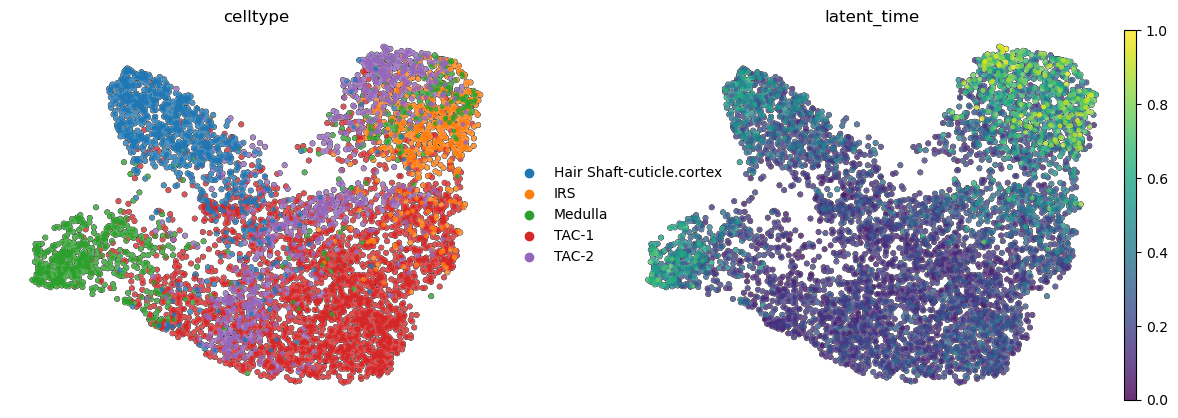

In [7]:

adata_mvi.obsm["latent"] = latent_expr
# sc.pp.neighbors(adata_mvi, use_rep = 'latent', metric = 'manhattan')
sc.pp.neighbors(adata_mvi, use_rep = 'latent')

sc.tl.umap(adata_mvi, min_dist=0.1)

sc.pl.umap(adata_mvi, frameon=False, size = 50, alpha = 0.8, add_outline=True,
          outline_width=(0.1,0), color=['celltype', 'latent_time'])

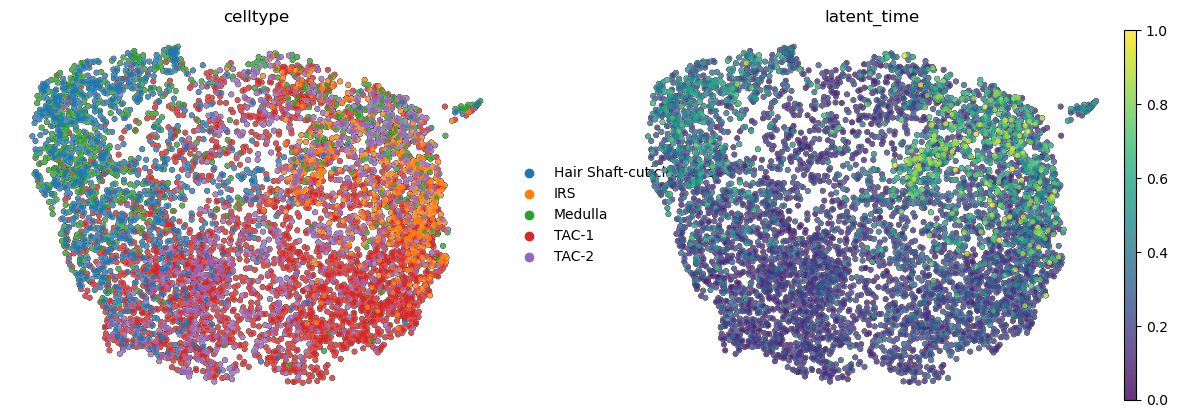

In [10]:
adata_mvi.obsm["latent"] = latent_acc
# sc.pp.neighbors(adata_mvi, use_rep = 'latent', metric = 'manhattan')
sc.pp.neighbors(adata_mvi, use_rep = 'latent')

sc.tl.umap(adata_mvi, min_dist=0.1)

sc.pl.umap(adata_mvi, frameon=False, size = 50, alpha = 0.8, add_outline=True,
          outline_width=(0.1,0), color=['celltype', 'latent_time'])

## Causal representations


Epoch 3/800:   0%|          | 2/800 [16:36<110:23:32, 498.01s/it, loss=9.06e+05, v_num=1]


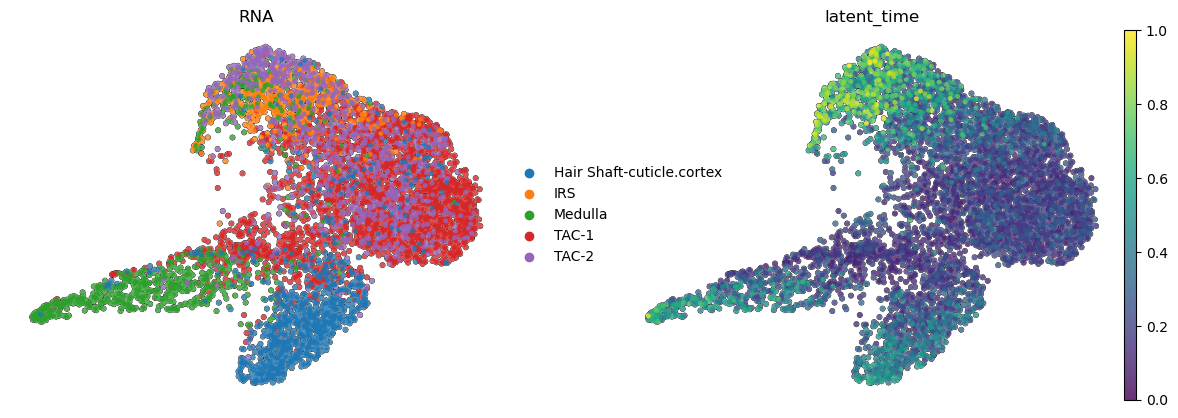

In [16]:
adata_mvi.obsm["latent"] = latent_expr
# sc.pp.neighbors(adata_mvi, use_rep = 'latent', metric = 'manhattan')
sc.pp.neighbors(adata_mvi, use_rep = 'latent')

sc.tl.umap(adata_mvi, min_dist=0.2)

sc.pl.umap(adata_mvi, frameon=False, size = 50, alpha = 0.8, add_outline=True,
          outline_width=(0.1,0), color=['celltype', 'latent_time'], title="RNA")

In [38]:
gene_name = adata_mvi.var[adata_mvi.var.modality=="Gene Expression"]

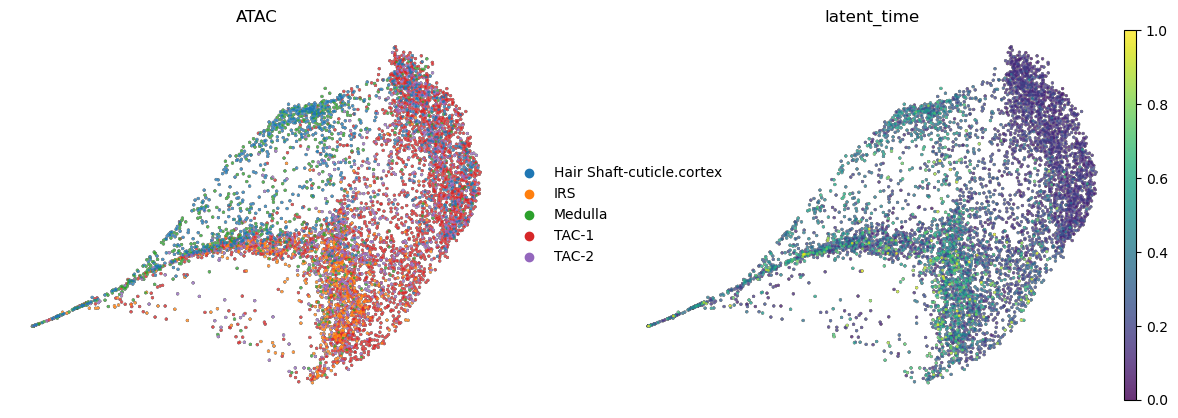

In [48]:
adata_mvi.obsm["latent"] = latent_acc
# sc.pp.neighbors(adata_mvi, use_rep = 'latent',n_neighbors=15)
# sc.tl.umap(adata_mvi, min_dist=0.1)


sc.pp.neighbors(adata_mvi, use_rep = 'latent',n_neighbors=15, metric = 'manhattan')
# sc.tl.umap(adata_mvi, min_dist=0.1)

sc.tl.umap(adata_mvi, min_dist=0.1, negative_sample_rate=0.1)



sc.pl.umap(adata_mvi, frameon=False, size = 15, alpha = 0.8, add_outline=True,
          outline_width=(0.1,0), color=['celltype','latent_time'], title="ATAC")

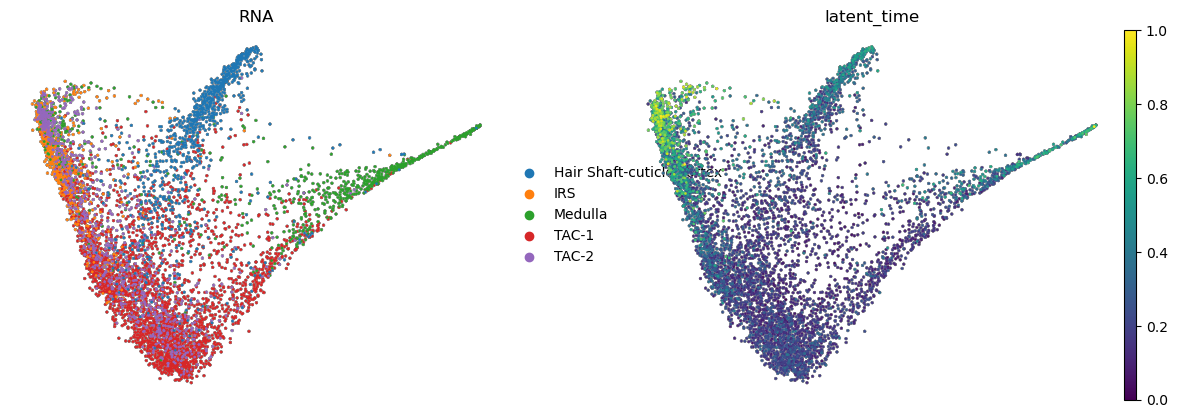

In [42]:
# adata_mvi.obsm["latent"] = np.concatenate((latent_atac_dep, latent_expr), axis=1)
adata_mvi.obsm["latent"] = latent_expr

sc.pp.neighbors(adata_mvi, use_rep = 'latent',n_neighbors=15, metric = 'manhattan')
# sc.tl.umap(adata_mvi, min_dist=0.1)

sc.tl.umap(adata_mvi, min_dist=0.1, negative_sample_rate=0.1)

# sc.pl.umap(rna_data, frameon=False, size = 10, alpha = 1, add_outline=True,
#           outline_width=(0.1,0), color='leiden')


sc.pl.umap(adata_mvi, frameon=False, size = 15, alpha = 1, add_outline=True,
          outline_width=(0.1,0), color=['celltype','latent_time'], title="RNA")

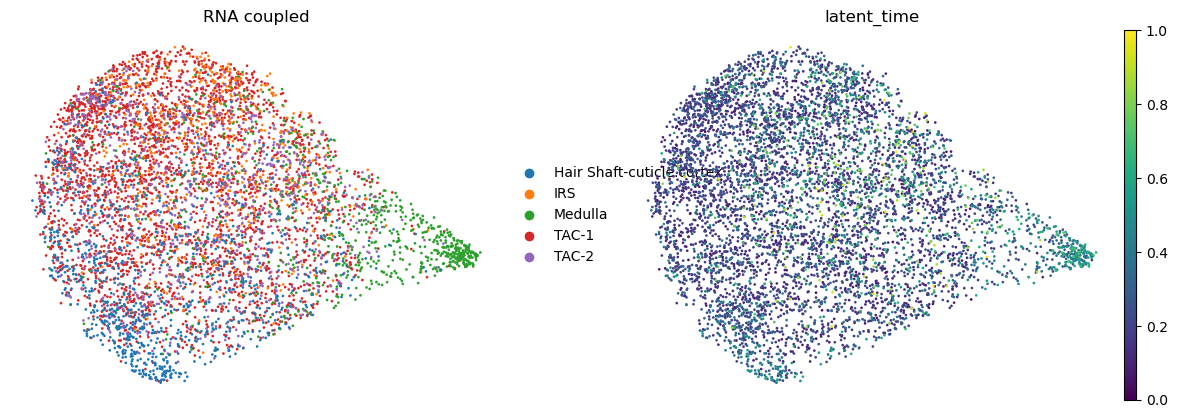

In [45]:
adata_mvi.obsm["latent"] =latent_expr_dep
# sc.pp.neighbors(adata_mvi, use_rep="latent")



# sc.tl.umap(adata_mvi,min_dist =0.5)

sc.pp.neighbors(adata_mvi, use_rep = 'latent',n_neighbors=15, metric = 'manhattan')
# sc.tl.umap(adata_mvi, min_dist=0.1)

sc.tl.umap(adata_mvi, min_dist=0.1, negative_sample_rate=0.1)

%matplotlib inline
sc.pl.umap(adata_mvi,color=['celltype', "latent_time"], s=15, alpha = 1, frameon=False, ncols=2,outline_width=(0.1,0), title="RNA coupled")


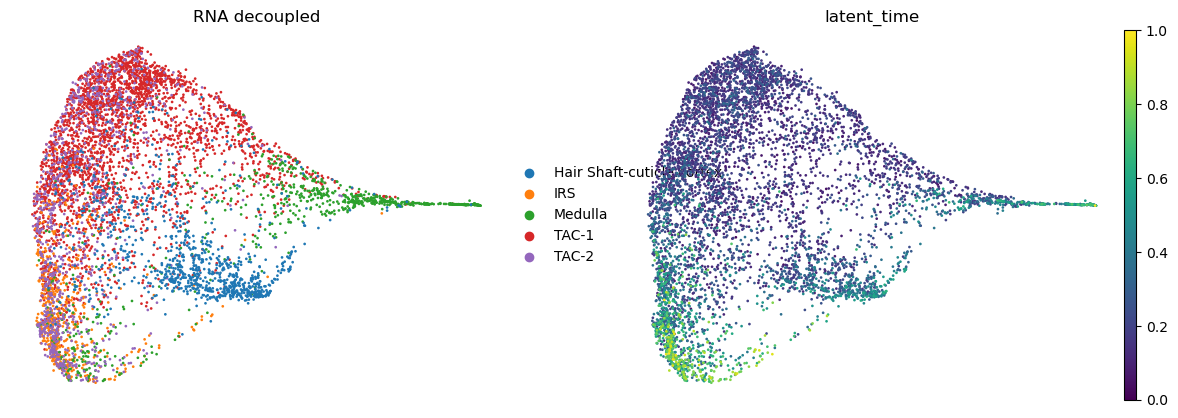

In [44]:
adata_mvi.obsm["latent"] =latent_expr_indep
# sc.pp.neighbors(adata_mvi, use_rep="latent")
# sc.tl.umap(adata_mvi,min_dist =0.1)


sc.pp.neighbors(adata_mvi, use_rep = 'latent',n_neighbors=15, metric = 'manhattan')
sc.tl.umap(adata_mvi, min_dist=0.1, negative_sample_rate=0.1)

%matplotlib inline
sc.pl.umap(adata_mvi,color=['celltype', "latent_time"], s=15, alpha =1 ,frameon=False, ncols=2, outline_width=(0.1,0), title="RNA decoupled")



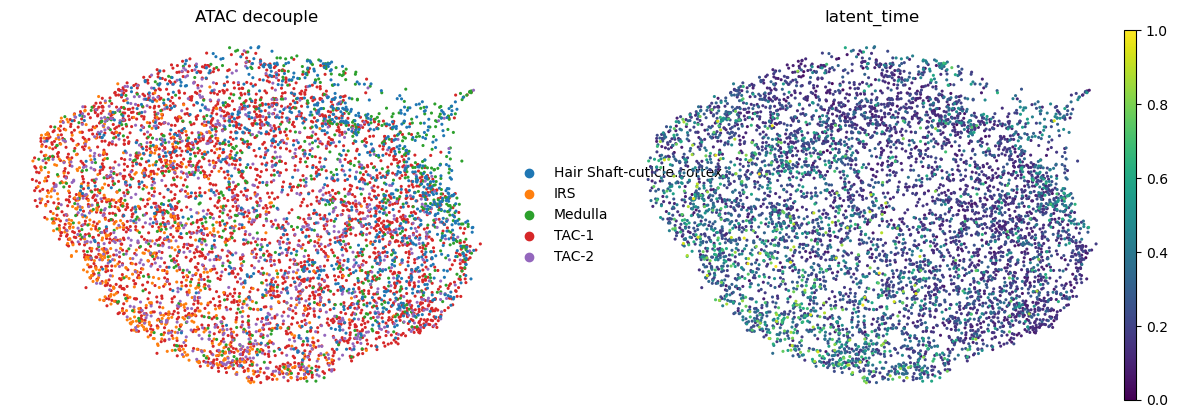

In [46]:
adata_mvi.obsm["latent"] =latent_atac_indep
sc.pp.neighbors(adata_mvi, use_rep = 'latent',n_neighbors=15, metric = 'manhattan')
sc.tl.umap(adata_mvi, min_dist=0.1, negative_sample_rate=0.1)

sc.pl.umap(adata_mvi,color=['celltype', "latent_time"], s=20, frameon=False, ncols=2,outline_width=(0.1,0), title="ATAC decouple", alpha = 1)


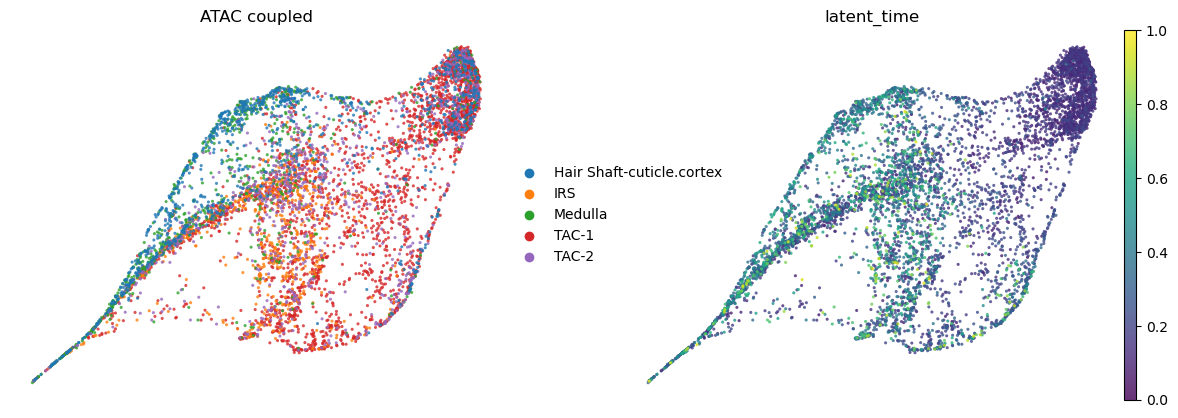

In [47]:
adata_mvi.obsm["latent"] =latent_atac_dep

sc.pp.neighbors(adata_mvi, use_rep = 'latent',n_neighbors=15, metric = 'manhattan')
sc.tl.umap(adata_mvi, min_dist=0.1, negative_sample_rate=0.1)

sc.pl.umap(adata_mvi,color=['celltype', "latent_time"], s=20, frameon=False, ncols=2, outline_width=(0.1, 0), title="ATAC coupled", alpha = 0.8)

